# Notebook to explore the potential use of GPU for AT2017gfo PE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import arviz
import time
import copy

# TODO these scipy imports are going to break things?
from jax.scipy.stats import truncnorm
from scipy.interpolate import interp1d

# NMMA imports
import nmma as nmma
from nmma.em.io import loadEvent
from nmma.em.model import SVDLightCurveModel
from nmma.em.utils import get_calc_lc_jit
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans

import inspect 
import nmma.em.model_parameters as model_parameters

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}

model_name = "Bu2022Ye"
model_function = MODEL_FUNCTIONS[model_name]

# jax imports
import jax
import jaxlib
import jax.numpy as jnp

params = {"axes.grid": True,
        "text.usetex" : False, # TODO enable latex, but this breaks if filters have underscore
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

print("Checking if CUDA is found:")
print(jax.devices())

/home/urash/twouters/miniconda3/envs/nmma_gpu/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Install afterglowpy if you want to simulate afterglows.
Install wrapt_timeout_decorator if you want timeout simulations.
Checking if CUDA is found:


/home/urash/twouters/miniconda3/envs/nmma_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[cuda(id=0)]


# Explore data

Load in the data

**TODO**: for now, I am ignoring non inf datapoints for simplicity. Have to extend to include inf datapoints as well.

**TODO**: Not sure if t can also be just the times we want to have, i.e., the times of the datapoints? Can reduce memory and improve efficiency>?

In [2]:
data_file = "../data/AT2017gfo_no_inf.dat"
trigger_time = 57982.5285236896
tmin, tmax = 0.05, 14
data = loadEvent(data_file)
# Read the LC dataset and interpolate the NaNs, and get training data
lcs_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/lcs_bulla_2022" # for remote SSH Potsdam
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
lc_dataset = read_photometry_files(full_filenames)
lc_dataset = interpolate_nans(lc_dataset)
training_data, parameters = model_function(lc_dataset)
filters = list(data.keys())
print("Filters:")
print(filters)

sample_times = jnp.linspace(tmin, tmax, 1000)

Filters:
['ps1__g', 'ps1__r', 'ps1__i', 'ps1__z', 'ps1__y', '2massj', '2massh', '2massks', 'sdssu']


Plot the data

No handles with labels found to put in legend.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif


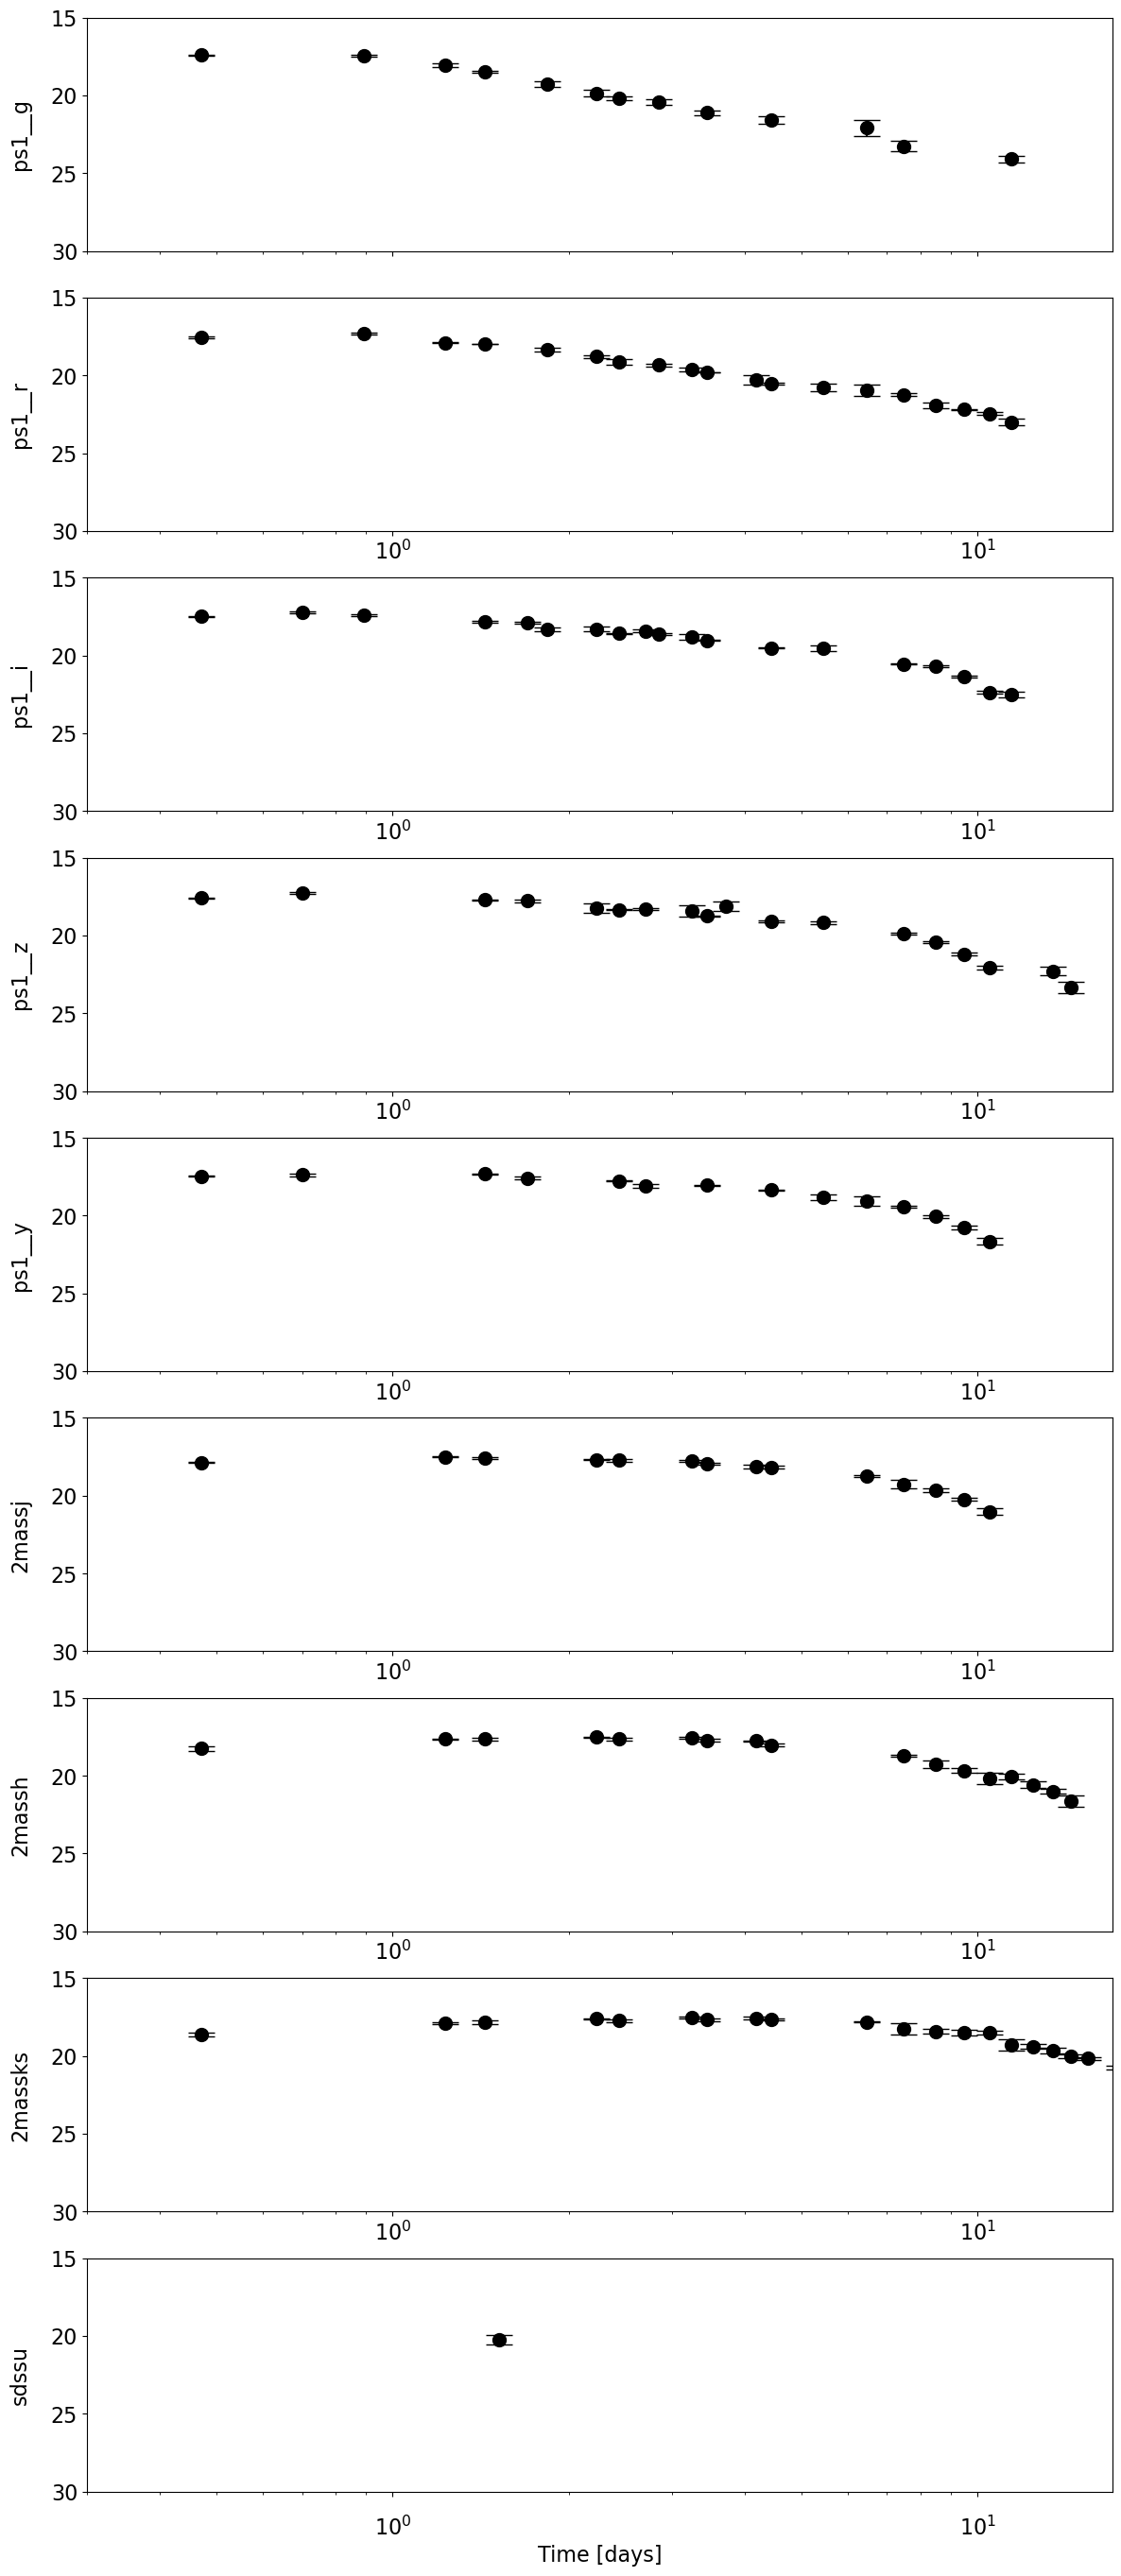

In [3]:
### Plot hyperparameters
set_ylim = True
set_yticks = True
show_legend = False

error_budget = '1.0'
error_budget = [float(x) for x in error_budget.split(",")]
error_budget = dict(zip(filters, error_budget * len(filters)))
xlim = f"{tmin},{tmax}"
ylim = "32, 15"
x_left = 3e-1
x_right = tmax + 3

# colors = cm.Spectral(np.linspace(0, 1, len(filters)))[::-1]

plt.figure(figsize=(14, 34))

cnt = 0
for filt in filters:
    cnt = cnt + 1
    if cnt == 1:
        ax1 = plt.subplot(len(filters), 1, cnt)
    elif cnt == 2 or cnt == 3:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)
    else:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)

    samples = data[filt]
    t, y, sigma_y = copy.deepcopy(samples[:, 0]), copy.deepcopy(samples[:, 1]), copy.deepcopy(samples[:, 2])
    t -= trigger_time   
    idx = np.where(~np.isnan(y))[0]
    t, y, sigma_y = t[idx], y[idx], sigma_y[idx]

    # 1) plot data points
    idx = np.where(np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="o", color='k', markersize=10, capsize=10)
    # plot upper bounds
    idx = np.where(~np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="v", color='k', markersize=10, capsize=10)

    #plt.ylim([float(x) for x in ylim.split(",")])
    plt.xlim([float(x) for x in xlim.split(",")])
    plt.xscale('log')
    plt.grid()
    
    filt_label = filt
    
    if cnt == 1:
        
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax1.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])
    else:
        # filt_label = filt.replace("__", "-")
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax2.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])

    if cnt == 1:
        if set_yticks:
            ax1.set_yticks([30, 25, 20, 15])
        else:
            ax1.invert_yaxis()
        ax1.set_xlim(left=x_left, right=x_right)
        plt.setp(ax1.get_xticklabels(), visible=False)
        legend = plt.legend(loc = "center", bbox_to_anchor=(0.5, 1.2), shadow=False,
                            fancybox=True, ncol=4)
        legend.get_frame().set_alpha(None)
    else:
        if set_yticks:
            ax2.set_yticks([30, 25, 20, 15])
        else:
            ax2.invert_yaxis()
        ax2.set_xlim(left=x_left, right=x_right)
    

ax1.set_zorder(1)
plt.xlabel("Time [days]")
ax2.tick_params(axis='x', which='major', pad=15)
#plt.legend(bbox_to_anchor=(0., 12.9, 1.025, .0), ncol=2, fontsize=40, frameon=True)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0)

if not show_legend:
    legend.remove()

plt.show()

## LC model

In [4]:
svd_path = "/home/urash/twouters/nmma_models/flax_models/"

lc_model = SVDLightCurveModel(
        model_name,
        t,
        svd_path=svd_path,
        parameter_conversion=None,
        mag_ncoeff=10,
        lbol_ncoeff=None,
        interpolation_type="flax",
        model_parameters=None,
        filters=filters,
        local_only=True
)

/home/urash/twouters/nmma_models/flax_models/Bu2022Ye.pkl


Function to generate light curves with jit:

NOTE: sample times must be the same here as within the log-likelihood call, it cannot be changed for now.

In [5]:
calc_lc_given_params_jit = get_calc_lc_jit(sample_times, svd_mag_model=lc_model.svd_mag_model, filters=filters)

# test it:
test_params = jnp.array([-2.30103, 0.12, 0.3, -1.30103, 0.03, 25.84])
_, _, test_lc = calc_lc_given_params_jit(test_params)
# TODO is this correct?
# Convert from jax numpy to just numpy
test_lc_np = {f: np.asarray(test_lc[f]) for f in filters}

# test_lc_np

## Inference with flowMC

In [6]:
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.sampler.MALA import MALA
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.nfmodel.utils import *

### Priors

Look at `/home/urash/twouters/gpu_projects/KN_inference/cpu/priors/AT2017gfo_Bu2022Ye_uniform_iota.prior`:
```markdown
luminosity_distance = 44
inclination_EM = Uniform(name='inclination_EM', minimum=0., maximum=np.pi/2., latex_label='$\\iota$')
log10_mej_dyn  = Uniform(name='log10_mej_dyn', minimum=-3, maximum=-1.7, latex_label='$\\log_{10}M^{\\rm{dyn}}_{\\rm{ej}}$')
vej_dyn = Uniform(name='vej_dyn', minimum=0.12, maximum=0.25, latex_label='$V^{\\rm{dyn}}_{\\rm{ej}}$')
Yedyn = Uniform(name='Yedyn', minimum=0.15, maximum=0.3, latex_label='$Y_{\\rm{e}}$')
log10_mej_wind = Uniform(name='log10_mej_wind', minimum=-2, maximum=-0.89, latex_label='$\\log_{10}M^{\\rm{wind}}_{\\rm{ej}}$')
vej_wind = Uniform(name='vej_wind', minimum=0.03, maximum=0.15, latex_label='$V^{\\rm{wind}}_{\\rm{ej}}$')
```

In [7]:
print(parameters)
prior_range = jnp.array([[-3, 1.7], [0.12, 0.25], [0.15, 0.3], [-2, 0.89], [-2, -0.89], [0, jnp.pi / 2]])
n_dim = len(prior_range)

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']


In [8]:
def top_hat(x):
    output = 0.
    for i in range(n_dim):
        output = jax.lax.cond(x[i]>=prior_range[i,0], lambda: output, lambda: -jnp.inf)
        output = jax.lax.cond(x[i]<=prior_range[i,1], lambda: output, lambda: -jnp.inf)
    return output

### Likelihood

In [9]:
# Helper function:

def truncated_gaussian(m_det, m_err, m_est, lim):

    a, b = (-jnp.inf - m_est) / m_err, (lim - m_est) / m_err
    logpdf = truncnorm.logpdf(m_det, a, b, loc=m_est, scale=m_err)

    return logpdf

Note: (some of) Peter's runs had luminosity distance either fixed to 44 or 50

In [10]:
# Make data a jnp array
for filt in filters:
    data[filt] = jnp.asarray(data[filt])

In [11]:
def log_likelihood(parameters, luminosity_distance=44):
    """
    Function taken from nmma/em/likelihood.py and adapted to this case here
    
    TODO: 
    - separate LC params from parameters?
    - add error budget
    - add timeshift
    - add luminosity distance
    - this is assuming all data are "finite" and the LC is finite. Not checking this here since breaks JAX jit
    """
    
    # Generate the light curve
    _, _, mag_abs = calc_lc_given_params_jit(parameters)
    mag_app_interp = {}
    
    for filt in filters:
        # TODO will this break things?
        # mag_abs_filt = nmma.em.utils.getFilteredMag(mag_abs, filt)
        mag_abs_filt = mag_abs[filt]
        
        mag_app_filt = mag_abs_filt + 5.0 * jnp.log10(
            luminosity_distance * 1e6 / 10.0
        )
        
        # Limit to finite magnitudes
        # TODO implement check for finite
        sample_times_used = sample_times
        mag_app_used = mag_app_filt
        
        # TODO timeshift zero for now, change this later on?
        t0 = 0
        mag_app_interp[filt] = lambda x: jnp.interp(x, sample_times_used + t0, mag_app_used, left="extrapolate", right="extrapolate")

    # Then, compare the estimated light curve and the measured data
    minus_chisquare_total = 0.0
    for filt in filters:
        # decompose the data
        data_time = copy.deepcopy(data[filt][:, 0])
        data_mag = copy.deepcopy(data[filt][:, 1])
        data_sigma = copy.deepcopy(data[filt][:, 2])

        ### TODO include the error budget into calculation
        error_budget = 1.0
        data_sigma = jnp.sqrt(data_sigma ** 2 + error_budget ** 2)

        # evaluate the light curve magnitude at the data points
        mag_est = mag_app_interp[filt](data_time)

        # TODO get detection limit?
        detection_limit = jnp.inf
        minus_chisquare = jnp.sum(
            truncated_gaussian(
                data_mag,
                data_sigma,
                mag_est,
                detection_limit,
            )
        )

        minus_chisquare_total += minus_chisquare

    log_prob = minus_chisquare_total

    return log_prob

In [12]:
test_logL = log_likelihood(test_params)
print(test_logL)

-100192920000.0


### Posterior

In [13]:
def posterior(theta, data):
    # NOTE: the data argument is unused?
    prior = top_hat(theta)
    return log_likelihood(theta) + prior

### Set up sampler

Initial position of chains

In [14]:
n_chains = 100

rng_key_set = initialize_rng_keys(n_chains, seed=42)

initial_position = jax.random.uniform(rng_key_set[0], shape=(int(n_chains), n_dim)) * 1
for i in range(n_dim):
    initial_position = initial_position.at[:,i].set(initial_position[:,i]*(prior_range[i,1]-prior_range[i,0])+prior_range[i,0])

In [37]:
model = MaskedCouplingRQSpline(n_dim, 10, [128,128], 8, jax.random.PRNGKey(42))

print("Initializing sampler class")

mass_matrix = jnp.eye(n_dim)
eps = 1e-8
# TODO any tuning to be done here?
posterior = posterior

local_sampler_arg = {"step_size": mass_matrix * eps}
use_jit = False
local_sampler = MALA(posterior, use_jit, local_sampler_arg)

Initializing sampler class


### Run the sampler

In [38]:
nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    None,
    local_sampler,
    model,
    n_loop_training=3,
    n_loop_production=3,
    n_local_steps=3,
    n_global_steps=3,
    n_chains=n_chains,
    n_epochs=100,
    learning_rate=0.001,
    max_samples=50000,
    momentum=0.9,
    batch_size=50000,
    use_global=True,
    keep_quantile=0.0,
    train_thinning=1,
    output_thinning=1,    
    local_sampler_arg=local_sampler_arg,
    outdir_name="./outdir/"
)

Note: without jitting, we get more print statements (as expected since that is a byproduct of the function), and the training loop takes around 4 minutes, production loop around 2 mins.

In [39]:
nf_sampler.sample(initial_position, None)

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:   0%|          | 0/3 [00:00<?, ?it/s]

Compiling MALA body
Compiling MALA body


Tuning global sampler:  33%|███▎      | 1/3 [02:05<04:10, 125.45s/it]

Compiling MALA body
Compiling MALA body


Tuning global sampler:  67%|██████▋   | 2/3 [02:50<01:18, 78.41s/it] 

Compiling MALA body
Compiling MALA body


Tuning global sampler: 100%|██████████| 3/3 [03:38<00:00, 72.69s/it]


Starting Production run


Production run:   0%|          | 0/3 [00:00<?, ?it/s]

Compiling MALA body
Compiling MALA body


Production run:  33%|███▎      | 1/3 [00:38<01:16, 38.32s/it]

Compiling MALA body
Compiling MALA body


Production run:  67%|██████▋   | 2/3 [01:18<00:39, 39.46s/it]

Compiling MALA body
Compiling MALA body


Production run: 100%|██████████| 3/3 [01:58<00:00, 39.55s/it]


## Postprocessing

Creating plots


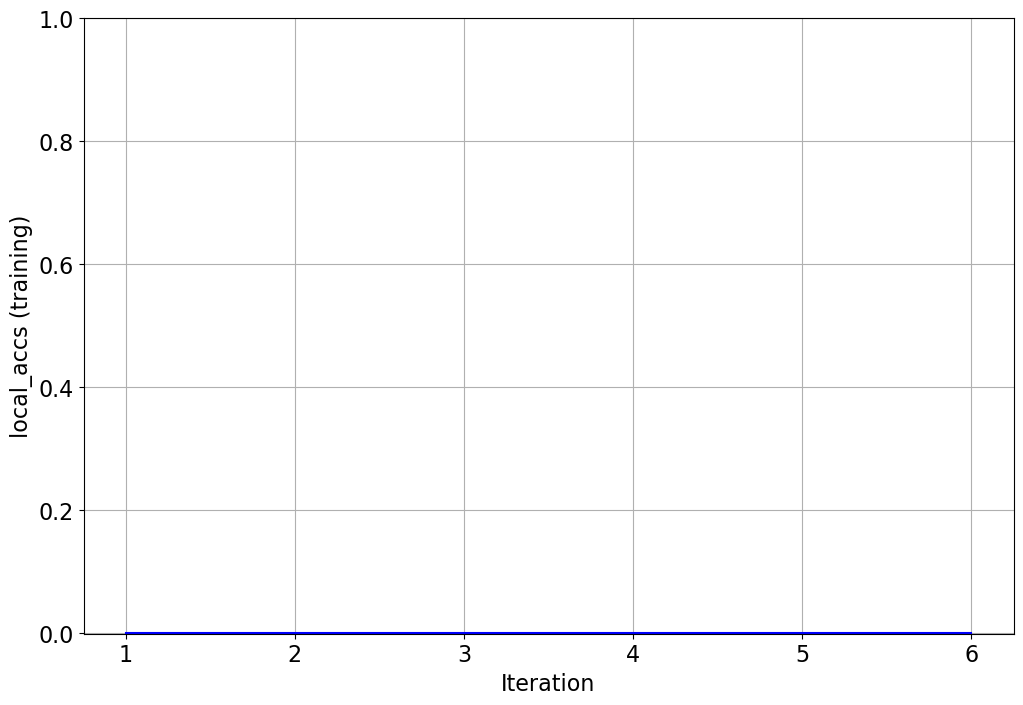

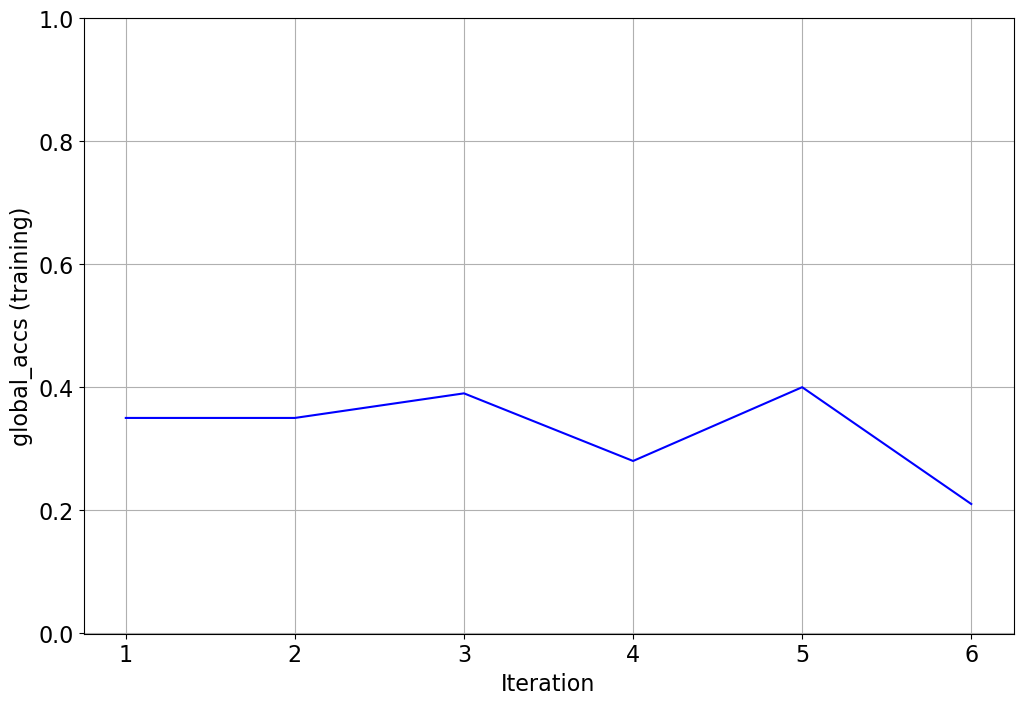

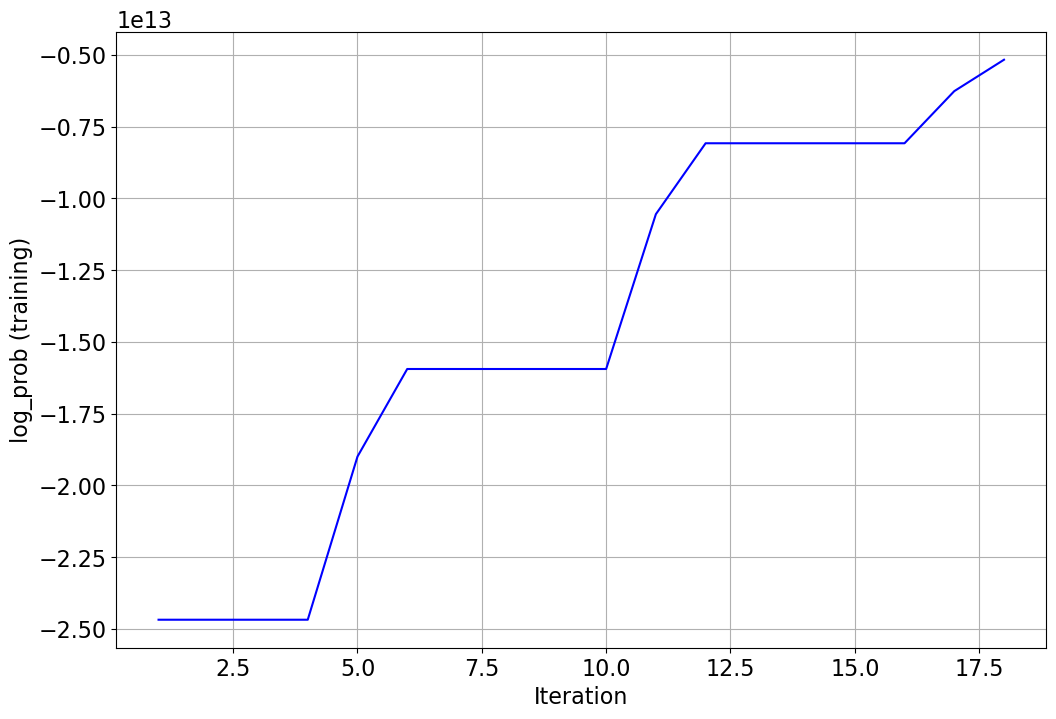

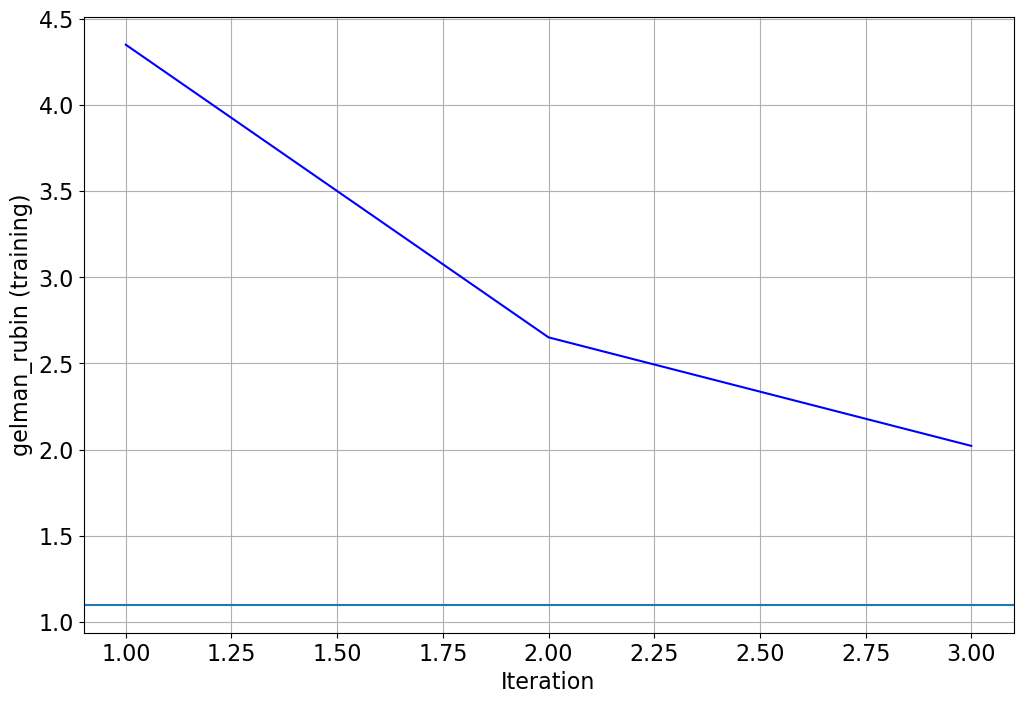

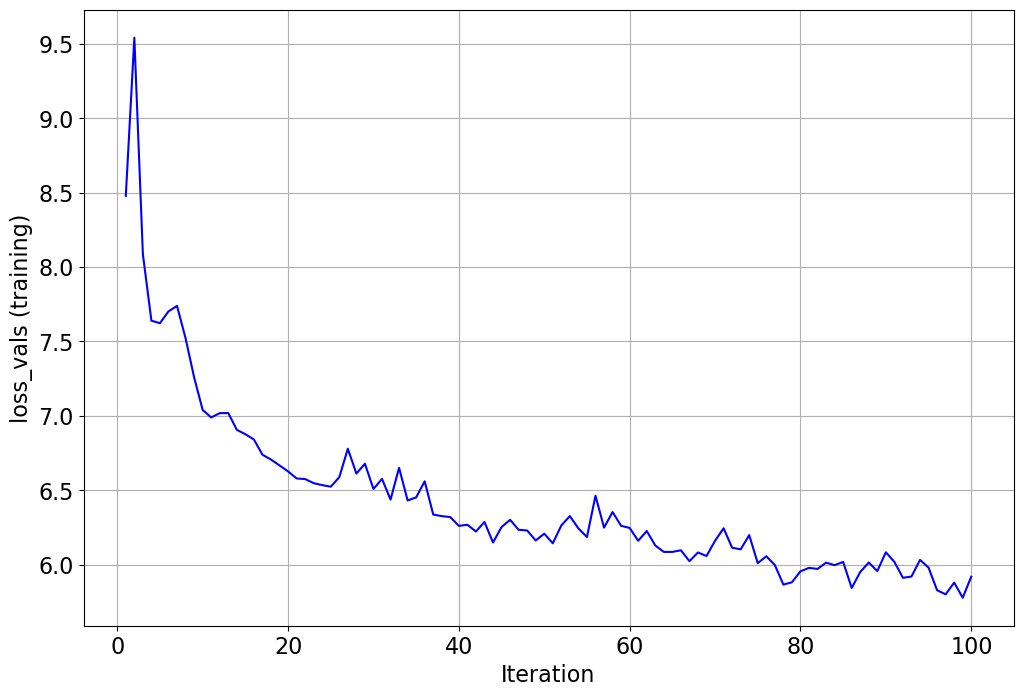

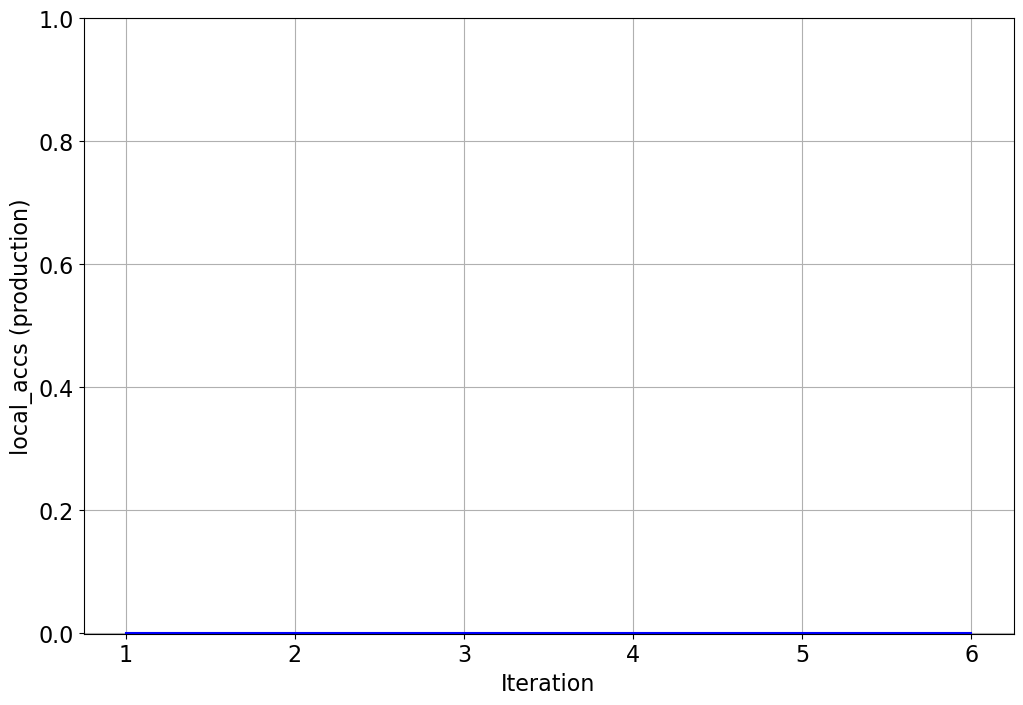

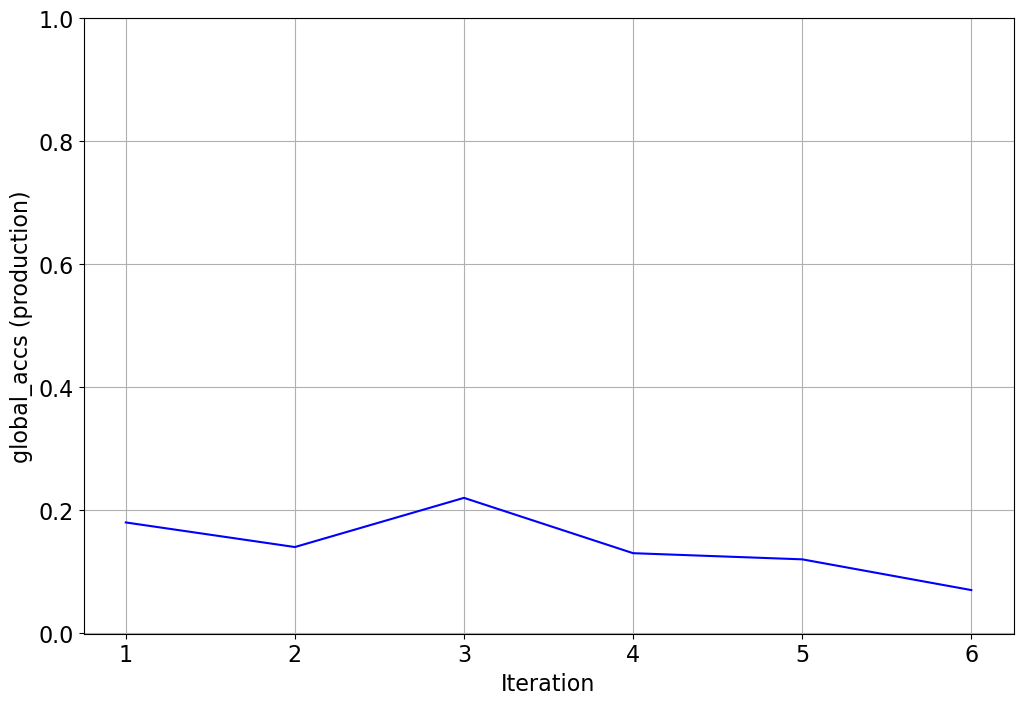

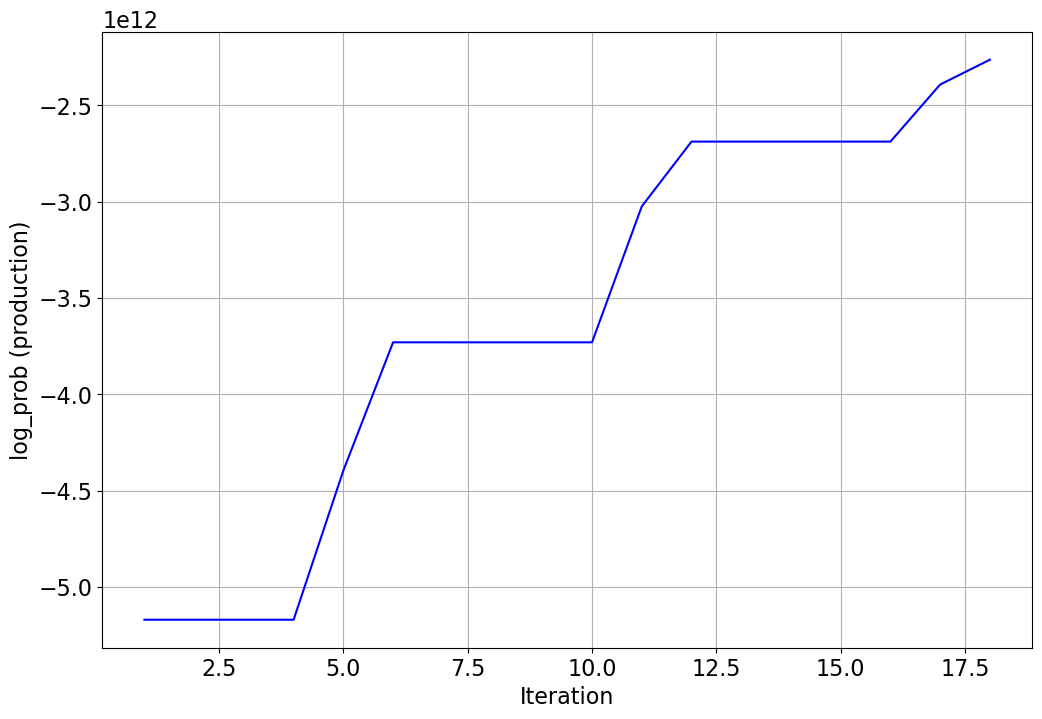

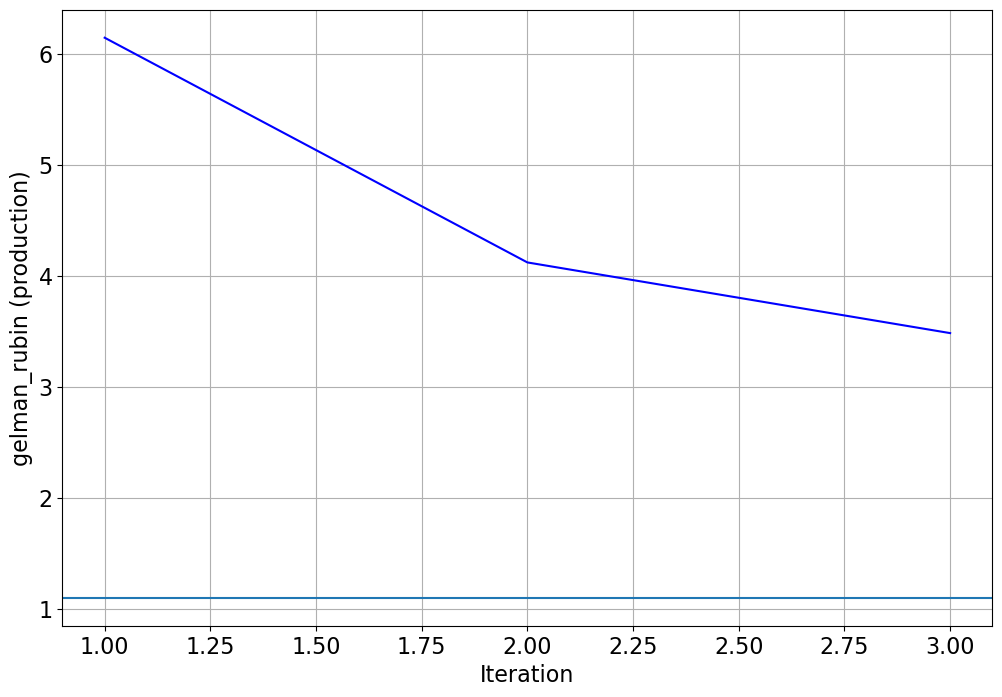

In [36]:
print("Creating plots")
nf_sampler.plot_summary("training")
nf_sampler.plot_summary("production")

## TODO, can we do inference with Numpyro?

**TODO**: Install numpyro and make sure it does not break the conda env again

**TODO**: Get likelihood etc?

In [ ]:
# import numpyro
# from numpyro.diagnostics import hpdi, summary
# import numpyro.distributions as dist
# from numpyro import handlers
# from numpyro.infer import MCMC, NUTS
# numpyro.set_platform("gpu")

In [ ]:
# def run_inference(
#     model, num_warmup=1000, num_samples=1000, max_tree_depth=10, dense_mass=False
# ):
#     kernel = NUTS(model, max_tree_depth=max_tree_depth, dense_mass=dense_mass)
#     mcmc = MCMC(
#         kernel,
#         num_warmup=num_warmup,
#         num_samples=num_samples,
#         num_chains=1,
#         progress_bar=False,
#     )
#     mcmc.run(jax.random.PRNGKey(0))
#     summary_dict = summary(mcmc.get_samples(), group_by_chain=False)

#     # print the largest r_hat for each variable
#     for k, v in summary_dict.items():
#         spaces = " " * max(12 - len(k), 0)
#         print("[{}] {} \t max r_hat: {:.4f}".format(k, spaces, np.max(v["r_hat"])))